6210407960 นายธนกร วงษ์สนิท

# Data augmentation using Generative Adversarial Networks (GANs)

In [1]:
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization

### Dataset

In [2]:
cd ./Dataset/Dataset3_GenImage/train

/data/home/b6210407960/Dataset/Dataset3_GenImage/train


In [3]:
ls

COVID/  GenImage/  Normal/


In [4]:
import os
import pandas as pd
import numpy as np

In [7]:
disease_types=['COVID']
path = '/data/home/b6210407960/Dataset/GenImage'
data_dir = os.path.join(path)

In [8]:
os.path.join(data_dir, disease_types[0])

'/data/home/b6210407960/Dataset/GenImage/COVID'

In [9]:
data = []
for id, level in enumerate(disease_types):
    for file in os.listdir(os.path.join(data_dir, level)):
        data.append(['{}/{}'.format(level, file), level])
        
data = pd.DataFrame(data, columns = ['image_file', 'result'])

In [10]:
data['path'] = path + '/' + data['image_file']
data['corona_result'] = data['result'].map({'Normal': 'Negative', 'COVID': 'Positive'})

In [11]:
# Data Reading 
from PIL import Image

data['image'] = data['path'].map(lambda x: np.asarray(Image.open(x).resize((64,64))))

data.head()

,image_file,result,path,corona_result,image
0,COVID/COVID-1.png,COVID,/data/home/b6210407960/Dataset/GenImage/COVID/...,Positive,"[[17, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
1,COVID/COVID-1175.png,COVID,/data/home/b6210407960/Dataset/GenImage/COVID/...,Positive,"[[6, 7, 9, 10, 13, 14, 15, 15, 14, 18, 15, 12,..."
2,COVID/COVID-1613.png,COVID,/data/home/b6210407960/Dataset/GenImage/COVID/...,Positive,"[[54, 41, 37, 44, 37, 33, 33, 33, 33, 33, 33, ..."
3,COVID/COVID-948.png,COVID,/data/home/b6210407960/Dataset/GenImage/COVID/...,Positive,"[[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 6, 6, 6, 5,..."
4,COVID/COVID-790.png,COVID,/data/home/b6210407960/Dataset/GenImage/COVID/...,Positive,"[[80, 24, 8, 6, 6, 19, 23, 1, 6, 5, 5, 5, 5, 5..."


In [12]:
IMAGE_SIZE = 64

def read_image(filepath):
    return cv2.imread(os.path.join(path, filepath)) 

def resize_image(image, image_size):
    # cv2.INTER_AREA: This is used when we need to shrink an image.
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)   

In [13]:
arr = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(data_dir, sp)):
        arr.append(['{}/{}'.format(sp, file), defects_id, sp]) #defectID-> Normal=0,COVID=1  
df = pd.DataFrame(arr, columns=['File', 'DiseaseID','Disease Type'])

In [14]:
df['File'].values

array(['COVID/COVID-1.png', 'COVID/COVID-1175.png',
       'COVID/COVID-1613.png', ..., 'COVID/COVID-789.png',
       'COVID/COVID-951.png', 'COVID/COVID-2465.png'], dtype=object)

In [15]:
ls

COVID/
COVID.zip
Newgenerator_200epoch.h5
Newgenerator_300epoch.h5
Newgenerator_500epoch.h5
Newgenerator_500epoch_latent150_v2_reOutputTraining.h5.h5
Newgenerator_50epoch.h5
__MACOSX/
generator.h5
generator_v100epoch.h5
generator_v100epoch_latent150.h5
generator_v200epoch_latent100.h5
generator_v200epoch_latent150.h5
generator_v50epoch.h5
generator_v50epoch_latent150.h5
newgenerator_10epoch.h5
results/
testGen/


In [16]:
from tqdm import tqdm
from PIL import Image
import cv2
dataset = np.zeros((df.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3)) #arrayไว้เก็บ image ที่อ่าน
# tqdm -> make your loops show a smart progress meter
for i, file in tqdm(enumerate(df['File'].values)):
    image = read_image(file)
    if image is not None:
        dataset[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
X_images = (dataset - 127.5) / 127.5
print(X_images.shape)

3697it [00:09, 408.32it/s]


(3697, 64, 64, 3)


In [17]:
dataset = X_images

## gen image uncon

In [6]:
# define the discriminator model
def define_discriminator(in_shape=(64,64,3)):
    model = Sequential()
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # classifier
    model.add(Flatten())
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model


# define the generator model
def define_generator(latent_dim):
    model = Sequential()
    n_nodes = 128 * 16 * 16
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((16, 16, 128)))
    # upsample
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # generate
    model.add(Conv2D(3, (8,8), activation='tanh', padding='same'))
    return model

# define the combined generator and discriminator model
def define_gan(generator, discriminator):
    discriminator.trainable = False
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    # class labels
    y = ones((n_samples, 1))
    return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    X = generator.predict(x_input)
    # class labels
    y = zeros((n_samples, 1))
    return X, y

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=200, n_batch=128):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    for i in range(n_epochs):
        for j in range(bat_per_epo):
            X_real, y_real = generate_real_samples(dataset, half_batch)
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            y_gan = ones((n_batch, 1))
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
                (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
    # save the generator model
    g_model.save('/data/home/b6210407960/Dataset/GenImage/generator_200epoch.h5')
 

In [7]:
latent_dim = 150 
generator = define_generator(latent_dim)
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32768)             4947968   
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32768)             0         
_________________________________________________________________
reshape (Reshape)            (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 32, 32, 128)       262272    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 64, 64, 128)       262272    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 64, 64, 128)       0

In [8]:
discriminator = define_discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 128)       3584      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       147584    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dropout (Dropout)            (None, 32768)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

/usr/local/lib/python3.6/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [9]:
latent_dim = 150
discriminator = define_discriminator()
generator = define_generator(latent_dim)

In [10]:
gan_model = define_gan(generator, discriminator)

In [24]:
# train model
train(generator, discriminator, gan_model, dataset, latent_dim)

>1, 1/28, d1=0.685, d2=0.696 g=0.622
>1, 2/28, d1=0.534, d2=0.700 g=0.497
>1, 3/28, d1=0.415, d2=0.705 g=0.380
>1, 4/28, d1=0.307, d2=0.709 g=0.275
>1, 5/28, d1=0.209, d2=0.713 g=0.196
>1, 6/28, d1=0.158, d2=0.715 g=0.143
>1, 7/28, d1=0.092, d2=0.714 g=0.111
>1, 8/28, d1=0.065, d2=0.710 g=0.094
>1, 9/28, d1=0.047, d2=0.705 g=0.084
>1, 10/28, d1=0.035, d2=0.698 g=0.079
>1, 11/28, d1=0.031, d2=0.690 g=0.077
>1, 12/28, d1=0.027, d2=0.681 g=0.075
>1, 13/28, d1=0.020, d2=0.670 g=0.075
>1, 14/28, d1=0.022, d2=0.655 g=0.074
>1, 15/28, d1=0.015, d2=0.639 g=0.074
>1, 16/28, d1=0.019, d2=0.618 g=0.069
>1, 17/28, d1=0.014, d2=0.595 g=0.063
>1, 18/28, d1=0.013, d2=0.567 g=0.055
>1, 19/28, d1=0.016, d2=0.535 g=0.045
>1, 20/28, d1=0.010, d2=0.498 g=0.040
>1, 21/28, d1=0.018, d2=0.456 g=0.032
>1, 22/28, d1=0.010, d2=0.410 g=0.027
>1, 23/28, d1=0.008, d2=0.363 g=0.024
>1, 24/28, d1=0.009, d2=0.317 g=0.017
>1, 25/28, d1=0.007, d2=0.274 g=0.013
>1, 26/28, d1=0.009, d2=0.232 g=0.008
>1, 27/28, d1=0.009, 

>8, 23/28, d1=0.000, d2=0.000 g=0.000
>8, 24/28, d1=0.000, d2=0.000 g=0.000
>8, 25/28, d1=0.000, d2=0.000 g=0.000
>8, 26/28, d1=0.000, d2=0.000 g=0.000
>8, 27/28, d1=0.000, d2=0.000 g=0.000
>8, 28/28, d1=0.001, d2=0.000 g=0.000
>9, 1/28, d1=0.000, d2=0.000 g=0.000
>9, 2/28, d1=0.000, d2=0.000 g=0.000
>9, 3/28, d1=0.000, d2=0.000 g=0.000
>9, 4/28, d1=0.000, d2=0.000 g=0.000
>9, 5/28, d1=0.000, d2=0.000 g=0.000
>9, 6/28, d1=0.000, d2=0.000 g=0.000
>9, 7/28, d1=0.000, d2=0.000 g=0.000
>9, 8/28, d1=0.000, d2=0.000 g=0.000
>9, 9/28, d1=0.000, d2=0.000 g=0.000
>9, 10/28, d1=0.000, d2=0.000 g=0.000
>9, 11/28, d1=0.000, d2=0.000 g=0.000
>9, 12/28, d1=0.000, d2=0.000 g=0.000
>9, 13/28, d1=0.001, d2=0.000 g=0.000
>9, 14/28, d1=0.000, d2=0.000 g=0.000
>9, 15/28, d1=0.000, d2=0.000 g=0.000
>9, 16/28, d1=0.000, d2=0.000 g=0.000
>9, 17/28, d1=0.000, d2=0.000 g=0.000
>9, 18/28, d1=0.000, d2=0.000 g=0.000
>9, 19/28, d1=0.000, d2=0.000 g=0.000
>9, 20/28, d1=0.000, d2=0.000 g=0.000
>9, 21/28, d1=0.000, 

>16, 12/28, d1=0.000, d2=0.000 g=0.000
>16, 13/28, d1=0.000, d2=0.000 g=0.000
>16, 14/28, d1=0.000, d2=0.000 g=0.000
>16, 15/28, d1=0.000, d2=0.000 g=0.000
>16, 16/28, d1=0.000, d2=0.000 g=0.000
>16, 17/28, d1=0.000, d2=0.000 g=0.000
>16, 18/28, d1=0.001, d2=0.000 g=0.000
>16, 19/28, d1=0.000, d2=0.000 g=0.000
>16, 20/28, d1=0.000, d2=0.000 g=0.000
>16, 21/28, d1=0.000, d2=0.000 g=0.000
>16, 22/28, d1=0.000, d2=0.001 g=0.000
>16, 23/28, d1=0.000, d2=0.000 g=0.000
>16, 24/28, d1=0.000, d2=0.001 g=0.000
>16, 25/28, d1=0.000, d2=0.002 g=0.001
>16, 26/28, d1=0.000, d2=0.010 g=0.065
>16, 27/28, d1=0.001, d2=19.679 g=4.529
>16, 28/28, d1=1.244, d2=6.212 g=2.931
>17, 1/28, d1=0.558, d2=0.830 g=2.954
>17, 2/28, d1=0.367, d2=0.040 g=2.044
>17, 3/28, d1=0.113, d2=0.171 g=1.390
>17, 4/28, d1=0.155, d2=0.867 g=2.783
>17, 5/28, d1=0.358, d2=0.100 g=3.360
>17, 6/28, d1=0.130, d2=0.030 g=3.135
>17, 7/28, d1=0.075, d2=0.012 g=2.503
>17, 8/28, d1=0.142, d2=0.011 g=1.616
>17, 9/28, d1=0.080, d2=0.037 g=

>23, 28/28, d1=0.661, d2=0.532 g=0.676
>24, 1/28, d1=0.476, d2=0.285 g=0.640
>24, 2/28, d1=0.610, d2=0.348 g=0.575
>24, 3/28, d1=0.568, d2=0.309 g=0.566
>24, 4/28, d1=0.531, d2=0.320 g=0.392
>24, 5/28, d1=0.350, d2=0.227 g=0.530
>24, 6/28, d1=0.418, d2=0.188 g=0.318
>24, 7/28, d1=0.539, d2=0.335 g=0.239
>24, 8/28, d1=0.231, d2=0.181 g=0.278
>24, 9/28, d1=0.327, d2=0.178 g=0.238
>24, 10/28, d1=0.335, d2=0.161 g=0.210
>24, 11/28, d1=0.242, d2=0.126 g=0.184
>24, 12/28, d1=0.312, d2=0.168 g=0.167
>24, 13/28, d1=0.364, d2=0.265 g=0.173
>24, 14/28, d1=0.215, d2=0.121 g=0.179
>24, 15/28, d1=0.293, d2=0.134 g=0.146
>24, 16/28, d1=0.263, d2=0.189 g=0.151
>24, 17/28, d1=0.179, d2=0.141 g=0.142
>24, 18/28, d1=0.347, d2=0.219 g=0.138
>24, 19/28, d1=0.315, d2=0.124 g=0.112
>24, 20/28, d1=0.347, d2=0.210 g=0.114
>24, 21/28, d1=0.230, d2=0.194 g=0.136
>24, 22/28, d1=0.212, d2=0.095 g=0.114
>24, 23/28, d1=0.279, d2=0.160 g=0.098
>24, 24/28, d1=0.187, d2=0.158 g=0.100
>24, 25/28, d1=0.234, d2=0.121 g=0

>31, 16/28, d1=0.287, d2=0.271 g=0.022
>31, 17/28, d1=0.291, d2=0.270 g=0.078
>31, 18/28, d1=0.384, d2=0.389 g=0.017
>31, 19/28, d1=0.315, d2=0.259 g=0.067
>31, 20/28, d1=0.328, d2=0.304 g=0.020
>31, 21/28, d1=0.177, d2=0.249 g=0.056
>31, 22/28, d1=0.335, d2=0.271 g=0.021
>31, 23/28, d1=0.294, d2=0.332 g=0.040
>31, 24/28, d1=0.346, d2=0.238 g=0.032
>31, 25/28, d1=0.234, d2=0.236 g=0.055
>31, 26/28, d1=0.382, d2=0.265 g=0.049
>31, 27/28, d1=0.279, d2=0.288 g=0.026
>31, 28/28, d1=0.206, d2=0.277 g=0.058
>32, 1/28, d1=0.343, d2=0.216 g=0.036
>32, 2/28, d1=0.322, d2=0.267 g=0.028
>32, 3/28, d1=0.295, d2=0.267 g=0.073
>32, 4/28, d1=0.436, d2=0.443 g=0.007
>32, 5/28, d1=0.235, d2=0.323 g=0.016
>32, 6/28, d1=0.322, d2=0.175 g=0.078
>32, 7/28, d1=0.377, d2=0.347 g=0.017
>32, 8/28, d1=0.195, d2=0.232 g=0.040
>32, 9/28, d1=0.356, d2=0.267 g=0.039
>32, 10/28, d1=0.241, d2=0.256 g=0.037
>32, 11/28, d1=0.266, d2=0.224 g=0.127
>32, 12/28, d1=0.559, d2=0.451 g=0.002
>32, 13/28, d1=0.643, d2=0.555 g=0

>39, 4/28, d1=0.413, d2=0.606 g=0.335
>39, 5/28, d1=0.561, d2=0.489 g=0.126
>39, 6/28, d1=0.573, d2=0.582 g=0.337
>39, 7/28, d1=0.705, d2=0.547 g=0.147
>39, 8/28, d1=0.593, d2=0.504 g=0.469
>39, 9/28, d1=0.609, d2=0.489 g=0.312
>39, 10/28, d1=0.465, d2=0.567 g=1.057
>39, 11/28, d1=0.706, d2=0.429 g=0.195
>39, 12/28, d1=0.340, d2=0.363 g=0.518
>39, 13/28, d1=0.413, d2=0.796 g=0.749
>39, 14/28, d1=0.807, d2=0.785 g=1.253
>39, 15/28, d1=1.161, d2=0.679 g=0.330
>39, 16/28, d1=0.465, d2=0.697 g=1.845
>39, 17/28, d1=1.143, d2=0.990 g=0.537
>39, 18/28, d1=0.609, d2=0.677 g=1.335
>39, 19/28, d1=0.794, d2=0.432 g=1.104
>39, 20/28, d1=0.698, d2=0.688 g=1.124
>39, 21/28, d1=0.697, d2=0.588 g=1.000
>39, 22/28, d1=0.865, d2=0.591 g=0.794
>39, 23/28, d1=0.634, d2=0.569 g=0.865
>39, 24/28, d1=0.854, d2=0.561 g=0.707
>39, 25/28, d1=0.823, d2=0.541 g=0.628
>39, 26/28, d1=0.764, d2=0.591 g=0.562
>39, 27/28, d1=0.619, d2=0.466 g=0.696
>39, 28/28, d1=0.762, d2=0.488 g=0.511
>40, 1/28, d1=0.685, d2=0.571 g

>46, 20/28, d1=0.149, d2=0.140 g=0.034
>46, 21/28, d1=0.117, d2=0.144 g=0.036
>46, 22/28, d1=0.196, d2=0.120 g=0.029
>46, 23/28, d1=0.153, d2=0.132 g=0.030
>46, 24/28, d1=0.150, d2=0.117 g=0.024
>46, 25/28, d1=0.131, d2=0.111 g=0.027
>46, 26/28, d1=0.112, d2=0.116 g=0.028
>46, 27/28, d1=0.156, d2=0.109 g=0.027
>46, 28/28, d1=0.148, d2=0.119 g=0.022
>47, 1/28, d1=0.149, d2=0.129 g=0.023
>47, 2/28, d1=0.111, d2=0.110 g=0.023
>47, 3/28, d1=0.135, d2=0.121 g=0.024
>47, 4/28, d1=0.170, d2=0.129 g=0.022
>47, 5/28, d1=0.143, d2=0.130 g=0.021
>47, 6/28, d1=0.120, d2=0.124 g=0.023
>47, 7/28, d1=0.158, d2=0.092 g=0.018
>47, 8/28, d1=0.111, d2=0.123 g=0.018
>47, 9/28, d1=0.142, d2=0.127 g=0.020
>47, 10/28, d1=0.134, d2=0.095 g=0.019
>47, 11/28, d1=0.153, d2=0.125 g=0.016
>47, 12/28, d1=0.114, d2=0.125 g=0.017
>47, 13/28, d1=0.130, d2=0.105 g=0.017
>47, 14/28, d1=0.168, d2=0.128 g=0.014
>47, 15/28, d1=0.111, d2=0.122 g=0.018
>47, 16/28, d1=0.159, d2=0.128 g=0.015
>47, 17/28, d1=0.117, d2=0.116 g=0

>54, 8/28, d1=0.068, d2=0.040 g=0.025
>54, 9/28, d1=0.072, d2=0.037 g=0.025
>54, 10/28, d1=0.048, d2=0.028 g=0.022
>54, 11/28, d1=0.074, d2=0.027 g=0.021
>54, 12/28, d1=0.069, d2=0.037 g=0.018
>54, 13/28, d1=0.077, d2=0.050 g=0.019
>54, 14/28, d1=0.050, d2=0.044 g=0.021
>54, 15/28, d1=0.037, d2=0.026 g=0.020
>54, 16/28, d1=0.078, d2=0.050 g=0.019
>54, 17/28, d1=0.100, d2=0.048 g=0.019
>54, 18/28, d1=0.051, d2=0.034 g=0.022
>54, 19/28, d1=0.053, d2=0.034 g=0.019
>54, 20/28, d1=0.048, d2=0.036 g=0.019
>54, 21/28, d1=0.039, d2=0.028 g=0.020
>54, 22/28, d1=0.059, d2=0.035 g=0.018
>54, 23/28, d1=0.044, d2=0.036 g=0.019
>54, 24/28, d1=0.055, d2=0.036 g=0.020
>54, 25/28, d1=0.048, d2=0.042 g=0.019
>54, 26/28, d1=0.034, d2=0.026 g=0.022
>54, 27/28, d1=0.058, d2=0.039 g=0.019
>54, 28/28, d1=0.061, d2=0.038 g=0.018
>55, 1/28, d1=0.038, d2=0.044 g=0.021
>55, 2/28, d1=0.053, d2=0.050 g=0.021
>55, 3/28, d1=0.053, d2=0.047 g=0.024
>55, 4/28, d1=0.068, d2=0.042 g=0.026
>55, 5/28, d1=0.064, d2=0.041 g

>61, 24/28, d1=0.287, d2=0.290 g=0.072
>61, 25/28, d1=0.373, d2=0.334 g=0.073
>61, 26/28, d1=0.363, d2=0.374 g=0.072
>61, 27/28, d1=0.331, d2=0.342 g=0.097
>61, 28/28, d1=0.375, d2=0.358 g=0.082
>62, 1/28, d1=0.336, d2=0.366 g=0.098
>62, 2/28, d1=0.360, d2=0.298 g=0.077
>62, 3/28, d1=0.506, d2=0.438 g=0.196
>62, 4/28, d1=0.466, d2=0.577 g=0.097
>62, 5/28, d1=0.343, d2=0.441 g=0.121
>62, 6/28, d1=0.569, d2=0.407 g=0.119
>62, 7/28, d1=0.382, d2=0.474 g=0.118
>62, 8/28, d1=0.428, d2=0.490 g=0.117
>62, 9/28, d1=0.459, d2=0.467 g=0.170
>62, 10/28, d1=0.502, d2=0.435 g=0.147
>62, 11/28, d1=0.622, d2=0.651 g=0.199
>62, 12/28, d1=0.481, d2=0.617 g=0.264
>62, 13/28, d1=0.599, d2=0.621 g=0.444
>62, 14/28, d1=0.790, d2=0.715 g=0.297
>62, 15/28, d1=1.504, d2=0.990 g=0.593
>62, 16/28, d1=0.983, d2=0.936 g=0.409
>62, 17/28, d1=1.091, d2=0.922 g=0.154
>62, 18/28, d1=0.972, d2=1.092 g=0.143
>62, 19/28, d1=0.524, d2=0.598 g=0.257
>62, 20/28, d1=0.849, d2=0.753 g=0.213
>62, 21/28, d1=0.589, d2=0.875 g=0

>69, 12/28, d1=0.348, d2=0.239 g=0.013
>69, 13/28, d1=0.250, d2=0.378 g=0.016
>69, 14/28, d1=0.229, d2=0.220 g=0.018
>69, 15/28, d1=0.242, d2=0.204 g=0.017
>69, 16/28, d1=0.338, d2=0.349 g=0.014
>69, 17/28, d1=0.292, d2=0.403 g=0.017
>69, 18/28, d1=0.438, d2=0.386 g=0.019
>69, 19/28, d1=0.386, d2=0.298 g=0.015
>69, 20/28, d1=0.418, d2=0.347 g=0.013
>69, 21/28, d1=0.241, d2=0.353 g=0.016
>69, 22/28, d1=0.281, d2=0.278 g=0.015
>69, 23/28, d1=0.328, d2=0.361 g=0.017
>69, 24/28, d1=0.346, d2=0.291 g=0.016
>69, 25/28, d1=0.287, d2=0.320 g=0.015
>69, 26/28, d1=0.296, d2=0.370 g=0.017
>69, 27/28, d1=0.282, d2=0.329 g=0.020
>69, 28/28, d1=0.471, d2=0.348 g=0.019
>70, 1/28, d1=0.438, d2=0.421 g=0.022
>70, 2/28, d1=0.375, d2=0.424 g=0.018
>70, 3/28, d1=0.289, d2=0.349 g=0.020
>70, 4/28, d1=0.357, d2=0.346 g=0.020
>70, 5/28, d1=0.308, d2=0.377 g=0.021
>70, 6/28, d1=0.356, d2=0.299 g=0.022
>70, 7/28, d1=0.308, d2=0.350 g=0.020
>70, 8/28, d1=0.456, d2=0.436 g=0.030
>70, 9/28, d1=0.474, d2=0.530 g=0

>76, 28/28, d1=0.287, d2=0.299 g=0.078
>77, 1/28, d1=0.468, d2=0.339 g=0.164
>77, 2/28, d1=0.429, d2=0.460 g=0.048
>77, 3/28, d1=0.385, d2=0.402 g=0.066
>77, 4/28, d1=0.392, d2=0.372 g=0.084
>77, 5/28, d1=0.351, d2=0.369 g=0.091
>77, 6/28, d1=0.362, d2=0.242 g=0.062
>77, 7/28, d1=0.386, d2=0.356 g=0.087
>77, 8/28, d1=0.358, d2=0.404 g=0.054
>77, 9/28, d1=0.321, d2=0.335 g=0.064
>77, 10/28, d1=0.326, d2=0.295 g=0.067
>77, 11/28, d1=0.332, d2=0.281 g=0.055
>77, 12/28, d1=0.319, d2=0.310 g=0.071
>77, 13/28, d1=0.365, d2=0.420 g=0.045
>77, 14/28, d1=0.356, d2=0.328 g=0.054
>77, 15/28, d1=0.364, d2=0.351 g=0.055
>77, 16/28, d1=0.319, d2=0.273 g=0.051
>77, 17/28, d1=0.312, d2=0.382 g=0.064
>77, 18/28, d1=0.381, d2=0.304 g=0.039
>77, 19/28, d1=0.469, d2=0.414 g=0.106
>77, 20/28, d1=0.618, d2=0.490 g=0.031
>77, 21/28, d1=0.328, d2=0.402 g=0.044
>77, 22/28, d1=0.317, d2=0.345 g=0.052
>77, 23/28, d1=0.379, d2=0.305 g=0.043
>77, 24/28, d1=0.308, d2=0.339 g=0.056
>77, 25/28, d1=0.319, d2=0.344 g=0

>84, 16/28, d1=0.102, d2=0.101 g=0.023
>84, 17/28, d1=0.082, d2=0.068 g=0.022
>84, 18/28, d1=0.098, d2=0.093 g=0.022
>84, 19/28, d1=0.135, d2=0.088 g=0.027
>84, 20/28, d1=0.134, d2=0.129 g=0.027
>84, 21/28, d1=0.125, d2=0.106 g=0.033
>84, 22/28, d1=0.075, d2=0.087 g=0.030
>84, 23/28, d1=0.111, d2=0.083 g=0.028
>84, 24/28, d1=0.105, d2=0.104 g=0.032
>84, 25/28, d1=0.111, d2=0.090 g=0.031
>84, 26/28, d1=0.070, d2=0.089 g=0.024
>84, 27/28, d1=0.121, d2=0.099 g=0.028
>84, 28/28, d1=0.108, d2=0.095 g=0.027
>85, 1/28, d1=0.073, d2=0.117 g=0.023
>85, 2/28, d1=0.093, d2=0.096 g=0.027
>85, 3/28, d1=0.166, d2=0.123 g=0.036
>85, 4/28, d1=0.132, d2=0.120 g=0.041
>85, 5/28, d1=0.136, d2=0.161 g=0.045
>85, 6/28, d1=0.090, d2=0.104 g=0.046
>85, 7/28, d1=0.133, d2=0.141 g=0.054
>85, 8/28, d1=0.127, d2=0.123 g=0.059
>85, 9/28, d1=0.136, d2=0.130 g=0.054
>85, 10/28, d1=0.137, d2=0.146 g=0.047
>85, 11/28, d1=0.131, d2=0.138 g=0.055
>85, 12/28, d1=0.157, d2=0.145 g=0.047
>85, 13/28, d1=0.136, d2=0.115 g=0

>92, 4/28, d1=0.152, d2=0.342 g=0.050
>92, 5/28, d1=0.302, d2=0.515 g=0.029
>92, 6/28, d1=0.331, d2=0.305 g=0.121
>92, 7/28, d1=0.390, d2=0.512 g=0.021
>92, 8/28, d1=0.854, d2=0.471 g=0.036
>92, 9/28, d1=0.291, d2=0.557 g=0.033
>92, 10/28, d1=0.350, d2=0.227 g=0.016
>92, 11/28, d1=0.409, d2=0.529 g=0.053
>92, 12/28, d1=0.277, d2=0.463 g=0.033
>92, 13/28, d1=0.322, d2=0.664 g=0.068
>92, 14/28, d1=0.446, d2=0.430 g=0.075
>92, 15/28, d1=0.520, d2=0.358 g=0.016
>92, 16/28, d1=0.673, d2=0.831 g=0.429
>92, 17/28, d1=0.864, d2=0.707 g=0.014
>92, 18/28, d1=0.411, d2=0.398 g=0.138
>92, 19/28, d1=0.664, d2=0.421 g=0.889
>92, 20/28, d1=0.950, d2=1.845 g=0.013
>92, 21/28, d1=0.211, d2=0.190 g=0.512
>92, 22/28, d1=0.437, d2=0.175 g=0.179
>92, 23/28, d1=0.105, d2=0.243 g=0.196
>92, 24/28, d1=0.326, d2=0.443 g=0.055
>92, 25/28, d1=0.529, d2=0.157 g=0.018
>92, 26/28, d1=0.149, d2=0.106 g=0.022
>92, 27/28, d1=0.137, d2=0.071 g=0.021
>92, 28/28, d1=0.143, d2=0.128 g=0.015
>93, 1/28, d1=0.105, d2=0.111 g

>99, 20/28, d1=0.064, d2=0.229 g=0.323
>99, 21/28, d1=0.059, d2=0.131 g=0.235
>99, 22/28, d1=0.449, d2=1.416 g=0.015
>99, 23/28, d1=0.205, d2=0.049 g=0.267
>99, 24/28, d1=0.395, d2=0.116 g=0.567
>99, 25/28, d1=0.589, d2=0.899 g=0.077
>99, 26/28, d1=0.186, d2=0.043 g=0.131
>99, 27/28, d1=0.363, d2=0.258 g=0.061
>99, 28/28, d1=0.178, d2=0.131 g=0.066
>100, 1/28, d1=0.200, d2=0.100 g=0.035
>100, 2/28, d1=0.086, d2=0.063 g=0.034
>100, 3/28, d1=0.196, d2=0.168 g=0.020
>100, 4/28, d1=0.066, d2=0.048 g=0.023
>100, 5/28, d1=0.149, d2=0.064 g=0.016
>100, 6/28, d1=0.221, d2=0.124 g=0.011
>100, 7/28, d1=0.095, d2=0.093 g=0.016
>100, 8/28, d1=0.124, d2=0.061 g=0.013
>100, 9/28, d1=0.197, d2=0.156 g=0.012
>100, 10/28, d1=0.115, d2=0.070 g=0.014
>100, 11/28, d1=0.139, d2=0.066 g=0.009
>100, 12/28, d1=0.148, d2=0.139 g=0.013
>100, 13/28, d1=0.059, d2=0.034 g=0.016
>100, 14/28, d1=0.139, d2=0.074 g=0.011
>100, 15/28, d1=0.061, d2=0.083 g=0.014
>100, 16/28, d1=0.187, d2=0.077 g=0.010
>100, 17/28, d1=0.

>107, 3/28, d1=0.231, d2=0.141 g=0.028
>107, 4/28, d1=0.324, d2=0.230 g=0.013
>107, 5/28, d1=0.147, d2=0.224 g=0.018
>107, 6/28, d1=0.204, d2=0.175 g=0.023
>107, 7/28, d1=0.163, d2=0.142 g=0.021
>107, 8/28, d1=0.197, d2=0.170 g=0.019
>107, 9/28, d1=0.151, d2=0.126 g=0.019
>107, 10/28, d1=0.143, d2=0.166 g=0.022
>107, 11/28, d1=0.133, d2=0.137 g=0.020
>107, 12/28, d1=0.185, d2=0.152 g=0.022
>107, 13/28, d1=0.129, d2=0.163 g=0.031
>107, 14/28, d1=0.166, d2=0.129 g=0.023
>107, 15/28, d1=0.205, d2=0.145 g=0.019
>107, 16/28, d1=0.163, d2=0.175 g=0.015
>107, 17/28, d1=0.156, d2=0.165 g=0.021
>107, 18/28, d1=0.175, d2=0.151 g=0.023
>107, 19/28, d1=0.174, d2=0.151 g=0.022
>107, 20/28, d1=0.134, d2=0.147 g=0.030
>107, 21/28, d1=0.190, d2=0.168 g=0.020
>107, 22/28, d1=0.160, d2=0.146 g=0.022
>107, 23/28, d1=0.166, d2=0.151 g=0.030
>107, 24/28, d1=0.141, d2=0.131 g=0.024
>107, 25/28, d1=0.133, d2=0.126 g=0.027
>107, 26/28, d1=0.167, d2=0.151 g=0.034
>107, 27/28, d1=0.181, d2=0.154 g=0.021
>107, 2

>114, 14/28, d1=0.040, d2=0.035 g=0.025
>114, 15/28, d1=0.028, d2=0.034 g=0.027
>114, 16/28, d1=0.050, d2=0.051 g=0.031
>114, 17/28, d1=0.025, d2=0.031 g=0.033
>114, 18/28, d1=0.035, d2=0.039 g=0.033
>114, 19/28, d1=0.038, d2=0.032 g=0.036
>114, 20/28, d1=0.050, d2=0.030 g=0.030
>114, 21/28, d1=0.015, d2=0.029 g=0.034
>114, 22/28, d1=0.021, d2=0.036 g=0.033
>114, 23/28, d1=0.028, d2=0.034 g=0.036
>114, 24/28, d1=0.035, d2=0.020 g=0.032
>114, 25/28, d1=0.046, d2=0.036 g=0.030
>114, 26/28, d1=0.026, d2=0.039 g=0.033
>114, 27/28, d1=0.019, d2=0.027 g=0.034
>114, 28/28, d1=0.043, d2=0.032 g=0.034
>115, 1/28, d1=0.033, d2=0.027 g=0.033
>115, 2/28, d1=0.049, d2=0.034 g=0.032
>115, 3/28, d1=0.038, d2=0.035 g=0.029
>115, 4/28, d1=0.023, d2=0.029 g=0.032
>115, 5/28, d1=0.051, d2=0.030 g=0.031
>115, 6/28, d1=0.019, d2=0.036 g=0.030
>115, 7/28, d1=0.019, d2=0.025 g=0.033
>115, 8/28, d1=0.035, d2=0.025 g=0.027
>115, 9/28, d1=0.042, d2=0.027 g=0.024
>115, 10/28, d1=0.022, d2=0.037 g=0.026
>115, 11/

>121, 25/28, d1=0.124, d2=0.100 g=0.020
>121, 26/28, d1=0.136, d2=0.082 g=0.015
>121, 27/28, d1=0.092, d2=0.068 g=0.016
>121, 28/28, d1=0.070, d2=0.069 g=0.012
>122, 1/28, d1=0.102, d2=0.081 g=0.012
>122, 2/28, d1=0.106, d2=0.101 g=0.011
>122, 3/28, d1=0.083, d2=0.085 g=0.016
>122, 4/28, d1=0.083, d2=0.082 g=0.014
>122, 5/28, d1=0.184, d2=0.149 g=0.028
>122, 6/28, d1=0.067, d2=0.088 g=0.022
>122, 7/28, d1=0.091, d2=0.070 g=0.019
>122, 8/28, d1=0.109, d2=0.085 g=0.022
>122, 9/28, d1=0.081, d2=0.076 g=0.019
>122, 10/28, d1=0.133, d2=0.144 g=0.029
>122, 11/28, d1=0.090, d2=0.089 g=0.033
>122, 12/28, d1=0.108, d2=0.100 g=0.035
>122, 13/28, d1=0.112, d2=0.097 g=0.023
>122, 14/28, d1=0.111, d2=0.128 g=0.021
>122, 15/28, d1=0.147, d2=0.143 g=0.037
>122, 16/28, d1=0.129, d2=0.104 g=0.029
>122, 17/28, d1=0.175, d2=0.177 g=0.026
>122, 18/28, d1=0.146, d2=0.147 g=0.034
>122, 19/28, d1=0.322, d2=0.241 g=0.031
>122, 20/28, d1=0.171, d2=0.138 g=0.041
>122, 21/28, d1=0.272, d2=0.243 g=0.068
>122, 22/

>129, 8/28, d1=0.051, d2=0.093 g=0.016
>129, 9/28, d1=0.044, d2=0.018 g=0.019
>129, 10/28, d1=0.043, d2=0.084 g=0.027
>129, 11/28, d1=0.056, d2=0.043 g=0.019
>129, 12/28, d1=0.174, d2=0.046 g=0.010
>129, 13/28, d1=0.055, d2=0.097 g=0.020
>129, 14/28, d1=0.040, d2=0.039 g=0.023
>129, 15/28, d1=0.065, d2=0.026 g=0.010
>129, 16/28, d1=0.036, d2=0.169 g=0.034
>129, 17/28, d1=0.069, d2=0.046 g=0.046
>129, 18/28, d1=0.055, d2=0.061 g=0.018
>129, 19/28, d1=0.044, d2=0.073 g=0.018
>129, 20/28, d1=0.045, d2=0.066 g=0.028
>129, 21/28, d1=0.114, d2=0.079 g=0.015
>129, 22/28, d1=0.063, d2=0.112 g=0.146
>129, 23/28, d1=0.179, d2=0.128 g=0.002
>129, 24/28, d1=0.208, d2=0.106 g=0.004
>129, 25/28, d1=0.030, d2=0.065 g=0.024
>129, 26/28, d1=0.075, d2=0.061 g=0.016
>129, 27/28, d1=0.058, d2=0.091 g=0.019
>129, 28/28, d1=0.036, d2=0.121 g=0.063
>130, 1/28, d1=0.152, d2=0.115 g=0.008
>130, 2/28, d1=0.039, d2=0.090 g=0.020
>130, 3/28, d1=0.180, d2=0.105 g=0.415
>130, 4/28, d1=0.442, d2=0.351 g=0.006
>130, 

>136, 19/28, d1=0.229, d2=0.218 g=0.057
>136, 20/28, d1=0.226, d2=0.190 g=0.002
>136, 21/28, d1=0.388, d2=0.378 g=0.044
>136, 22/28, d1=0.286, d2=0.159 g=0.002
>136, 23/28, d1=0.425, d2=0.361 g=0.039
>136, 24/28, d1=0.269, d2=0.201 g=0.006
>136, 25/28, d1=0.095, d2=0.112 g=0.007
>136, 26/28, d1=0.125, d2=0.157 g=0.013
>136, 27/28, d1=0.186, d2=0.197 g=0.023
>136, 28/28, d1=0.168, d2=0.165 g=0.019
>137, 1/28, d1=0.168, d2=0.117 g=0.012
>137, 2/28, d1=0.077, d2=0.131 g=0.029
>137, 3/28, d1=0.183, d2=0.152 g=0.010
>137, 4/28, d1=0.114, d2=0.172 g=0.017
>137, 5/28, d1=0.173, d2=0.121 g=0.009
>137, 6/28, d1=0.099, d2=0.126 g=0.013
>137, 7/28, d1=0.102, d2=0.121 g=0.018
>137, 8/28, d1=0.156, d2=0.106 g=0.010
>137, 9/28, d1=0.124, d2=0.193 g=0.022
>137, 10/28, d1=0.275, d2=0.215 g=0.025
>137, 11/28, d1=0.296, d2=0.283 g=0.019
>137, 12/28, d1=0.176, d2=0.205 g=0.055
>137, 13/28, d1=0.235, d2=0.279 g=0.032
>137, 14/28, d1=0.355, d2=0.208 g=0.570
>137, 15/28, d1=1.033, d2=2.250 g=1.524
>137, 16/

>144, 2/28, d1=0.109, d2=0.083 g=0.019
>144, 3/28, d1=0.164, d2=0.084 g=0.015
>144, 4/28, d1=0.088, d2=0.093 g=0.025
>144, 5/28, d1=0.096, d2=0.051 g=0.019
>144, 6/28, d1=0.109, d2=0.128 g=0.022
>144, 7/28, d1=0.193, d2=0.138 g=0.016
>144, 8/28, d1=0.082, d2=0.071 g=0.028
>144, 9/28, d1=0.114, d2=0.073 g=0.016
>144, 10/28, d1=0.077, d2=0.076 g=0.020
>144, 11/28, d1=0.102, d2=0.062 g=0.023
>144, 12/28, d1=0.116, d2=0.066 g=0.017
>144, 13/28, d1=0.081, d2=0.069 g=0.017
>144, 14/28, d1=0.091, d2=0.056 g=0.015
>144, 15/28, d1=0.046, d2=0.062 g=0.019
>144, 16/28, d1=0.114, d2=0.085 g=0.021
>144, 17/28, d1=0.116, d2=0.103 g=0.029
>144, 18/28, d1=0.111, d2=0.052 g=0.029
>144, 19/28, d1=0.148, d2=0.127 g=0.023
>144, 20/28, d1=0.044, d2=0.056 g=0.036
>144, 21/28, d1=0.156, d2=0.103 g=0.024
>144, 22/28, d1=0.071, d2=0.082 g=0.027
>144, 23/28, d1=0.190, d2=0.085 g=0.022
>144, 24/28, d1=0.053, d2=0.062 g=0.026
>144, 25/28, d1=0.142, d2=0.089 g=0.019
>144, 26/28, d1=0.044, d2=0.094 g=0.031
>144, 27

>151, 13/28, d1=0.045, d2=0.033 g=0.017
>151, 14/28, d1=0.080, d2=0.095 g=0.013
>151, 15/28, d1=0.071, d2=0.054 g=0.014
>151, 16/28, d1=0.077, d2=0.041 g=0.012
>151, 17/28, d1=0.042, d2=0.088 g=0.011
>151, 18/28, d1=0.090, d2=0.076 g=0.013
>151, 19/28, d1=0.048, d2=0.087 g=0.021
>151, 20/28, d1=0.094, d2=0.049 g=0.018
>151, 21/28, d1=0.126, d2=0.085 g=0.018
>151, 22/28, d1=0.061, d2=0.141 g=0.012
>151, 23/28, d1=0.230, d2=0.169 g=0.033
>151, 24/28, d1=0.083, d2=0.073 g=0.017
>151, 25/28, d1=0.176, d2=0.129 g=0.013
>151, 26/28, d1=0.052, d2=0.081 g=0.016
>151, 27/28, d1=0.110, d2=0.085 g=0.018
>151, 28/28, d1=0.048, d2=0.067 g=0.018
>152, 1/28, d1=0.068, d2=0.066 g=0.014
>152, 2/28, d1=0.140, d2=0.189 g=0.057
>152, 3/28, d1=0.137, d2=0.062 g=0.009
>152, 4/28, d1=0.188, d2=0.245 g=0.010
>152, 5/28, d1=0.050, d2=0.061 g=0.016
>152, 6/28, d1=0.189, d2=0.176 g=0.028
>152, 7/28, d1=0.087, d2=0.101 g=0.030
>152, 8/28, d1=0.073, d2=0.066 g=0.021
>152, 9/28, d1=0.091, d2=0.076 g=0.023
>152, 10/

>158, 24/28, d1=0.074, d2=0.063 g=0.005
>158, 25/28, d1=0.056, d2=0.029 g=0.005
>158, 26/28, d1=0.051, d2=0.054 g=0.006
>158, 27/28, d1=0.051, d2=0.044 g=0.007
>158, 28/28, d1=0.052, d2=0.037 g=0.006
>159, 1/28, d1=0.048, d2=0.050 g=0.008
>159, 2/28, d1=0.033, d2=0.025 g=0.010
>159, 3/28, d1=0.053, d2=0.038 g=0.005
>159, 4/28, d1=0.044, d2=0.040 g=0.008
>159, 5/28, d1=0.051, d2=0.048 g=0.007
>159, 6/28, d1=0.059, d2=0.061 g=0.005
>159, 7/28, d1=0.075, d2=0.085 g=0.008
>159, 8/28, d1=0.044, d2=0.027 g=0.010
>159, 9/28, d1=0.062, d2=0.031 g=0.007
>159, 10/28, d1=0.028, d2=0.048 g=0.011
>159, 11/28, d1=0.047, d2=0.021 g=0.007
>159, 12/28, d1=0.036, d2=0.050 g=0.009
>159, 13/28, d1=0.057, d2=0.027 g=0.008
>159, 14/28, d1=0.047, d2=0.048 g=0.006
>159, 15/28, d1=0.059, d2=0.048 g=0.005
>159, 16/28, d1=0.015, d2=0.019 g=0.009
>159, 17/28, d1=0.096, d2=0.114 g=0.007
>159, 18/28, d1=0.031, d2=0.020 g=0.021
>159, 19/28, d1=0.054, d2=0.020 g=0.010
>159, 20/28, d1=0.075, d2=0.059 g=0.006
>159, 21/

>166, 7/28, d1=0.025, d2=0.024 g=0.026
>166, 8/28, d1=0.098, d2=0.040 g=0.017
>166, 9/28, d1=0.031, d2=0.056 g=0.016
>166, 10/28, d1=0.053, d2=0.049 g=0.024
>166, 11/28, d1=0.101, d2=0.024 g=0.011
>166, 12/28, d1=0.080, d2=0.046 g=0.008
>166, 13/28, d1=0.052, d2=0.068 g=0.014
>166, 14/28, d1=0.042, d2=0.034 g=0.015
>166, 15/28, d1=0.092, d2=0.051 g=0.014
>166, 16/28, d1=0.090, d2=0.077 g=0.009
>166, 17/28, d1=0.097, d2=0.108 g=0.016
>166, 18/28, d1=0.096, d2=0.062 g=0.032
>166, 19/28, d1=0.199, d2=0.158 g=0.017
>166, 20/28, d1=0.204, d2=0.049 g=0.014
>166, 21/28, d1=0.072, d2=0.169 g=0.028
>166, 22/28, d1=0.185, d2=0.068 g=0.032
>166, 23/28, d1=0.090, d2=0.045 g=0.013
>166, 24/28, d1=0.087, d2=0.065 g=0.012
>166, 25/28, d1=0.098, d2=0.149 g=0.023
>166, 26/28, d1=0.216, d2=0.050 g=0.011
>166, 27/28, d1=0.148, d2=0.125 g=0.011
>166, 28/28, d1=0.079, d2=0.048 g=0.010
>167, 1/28, d1=0.060, d2=0.037 g=0.011
>167, 2/28, d1=0.112, d2=0.046 g=0.011
>167, 3/28, d1=0.049, d2=0.117 g=0.011
>167, 

>173, 18/28, d1=0.165, d2=0.106 g=0.006
>173, 19/28, d1=0.122, d2=0.137 g=0.008
>173, 20/28, d1=0.174, d2=0.167 g=0.007
>173, 21/28, d1=0.099, d2=0.090 g=0.008
>173, 22/28, d1=0.166, d2=0.156 g=0.005
>173, 23/28, d1=0.099, d2=0.150 g=0.007
>173, 24/28, d1=0.208, d2=0.211 g=0.006
>173, 25/28, d1=0.080, d2=0.081 g=0.010
>173, 26/28, d1=0.170, d2=0.220 g=0.007
>173, 27/28, d1=0.123, d2=0.135 g=0.009
>173, 28/28, d1=0.143, d2=0.143 g=0.006
>174, 1/28, d1=0.218, d2=0.269 g=0.008
>174, 2/28, d1=0.158, d2=0.129 g=0.010
>174, 3/28, d1=0.166, d2=0.149 g=0.009
>174, 4/28, d1=0.216, d2=0.178 g=0.004
>174, 5/28, d1=0.107, d2=0.132 g=0.005
>174, 6/28, d1=0.157, d2=0.147 g=0.006
>174, 7/28, d1=0.134, d2=0.163 g=0.007
>174, 8/28, d1=0.152, d2=0.140 g=0.006
>174, 9/28, d1=0.173, d2=0.187 g=0.005
>174, 10/28, d1=0.175, d2=0.221 g=0.008
>174, 11/28, d1=0.147, d2=0.144 g=0.014
>174, 12/28, d1=0.428, d2=0.445 g=0.009
>174, 13/28, d1=0.269, d2=0.162 g=0.012
>174, 14/28, d1=0.410, d2=0.291 g=0.002
>174, 15/

>181, 1/28, d1=0.015, d2=0.017 g=0.010
>181, 2/28, d1=0.038, d2=0.017 g=0.011
>181, 3/28, d1=0.018, d2=0.026 g=0.008
>181, 4/28, d1=0.014, d2=0.016 g=0.007
>181, 5/28, d1=0.017, d2=0.013 g=0.006
>181, 6/28, d1=0.019, d2=0.019 g=0.006
>181, 7/28, d1=0.027, d2=0.024 g=0.007
>181, 8/28, d1=0.018, d2=0.019 g=0.009
>181, 9/28, d1=0.023, d2=0.014 g=0.006
>181, 10/28, d1=0.024, d2=0.023 g=0.006
>181, 11/28, d1=0.017, d2=0.016 g=0.006
>181, 12/28, d1=0.013, d2=0.013 g=0.007
>181, 13/28, d1=0.016, d2=0.013 g=0.007
>181, 14/28, d1=0.023, d2=0.016 g=0.006
>181, 15/28, d1=0.013, d2=0.022 g=0.008
>181, 16/28, d1=0.016, d2=0.013 g=0.008
>181, 17/28, d1=0.019, d2=0.016 g=0.007
>181, 18/28, d1=0.018, d2=0.014 g=0.006
>181, 19/28, d1=0.021, d2=0.015 g=0.005
>181, 20/28, d1=0.010, d2=0.022 g=0.006
>181, 21/28, d1=0.017, d2=0.012 g=0.008
>181, 22/28, d1=0.019, d2=0.018 g=0.008
>181, 23/28, d1=0.022, d2=0.012 g=0.007
>181, 24/28, d1=0.012, d2=0.012 g=0.006
>181, 25/28, d1=0.020, d2=0.013 g=0.005
>181, 26/

>188, 12/28, d1=0.002, d2=0.010 g=0.001
>188, 13/28, d1=0.016, d2=0.006 g=0.002
>188, 14/28, d1=0.002, d2=0.023 g=0.014
>188, 15/28, d1=0.004, d2=0.003 g=0.019
>188, 16/28, d1=0.000, d2=0.006 g=0.001
>188, 17/28, d1=0.005, d2=0.017 g=0.002
>188, 18/28, d1=0.009, d2=0.018 g=0.008
>188, 19/28, d1=0.002, d2=0.022 g=0.004
>188, 20/28, d1=0.011, d2=0.039 g=0.024
>188, 21/28, d1=0.007, d2=0.023 g=0.010
>188, 22/28, d1=0.003, d2=0.014 g=0.017
>188, 23/28, d1=0.001, d2=0.025 g=0.017
>188, 24/28, d1=0.003, d2=0.043 g=0.054
>188, 25/28, d1=0.002, d2=0.011 g=0.009
>188, 26/28, d1=0.004, d2=0.005 g=0.003
>188, 27/28, d1=0.002, d2=0.017 g=0.004
>188, 28/28, d1=0.019, d2=0.039 g=0.003
>189, 1/28, d1=0.006, d2=0.036 g=0.017
>189, 2/28, d1=0.005, d2=0.006 g=0.040
>189, 3/28, d1=0.003, d2=0.015 g=0.027
>189, 4/28, d1=0.012, d2=0.014 g=0.013
>189, 5/28, d1=0.008, d2=0.051 g=0.008
>189, 6/28, d1=0.011, d2=0.004 g=0.010
>189, 7/28, d1=0.014, d2=0.035 g=0.014
>189, 8/28, d1=0.005, d2=0.014 g=0.023
>189, 9/

>195, 23/28, d1=0.065, d2=0.019 g=0.058
>195, 24/28, d1=0.016, d2=0.033 g=0.063
>195, 25/28, d1=0.068, d2=0.024 g=0.078
>195, 26/28, d1=0.028, d2=0.006 g=0.035
>195, 27/28, d1=0.016, d2=0.008 g=0.033
>195, 28/28, d1=0.016, d2=0.009 g=0.020
>196, 1/28, d1=0.051, d2=0.087 g=0.090
>196, 2/28, d1=0.160, d2=0.006 g=0.018
>196, 3/28, d1=0.036, d2=0.020 g=0.007
>196, 4/28, d1=0.014, d2=0.004 g=0.008
>196, 5/28, d1=0.007, d2=0.006 g=0.011
>196, 6/28, d1=0.011, d2=0.006 g=0.008
>196, 7/28, d1=0.008, d2=0.006 g=0.009
>196, 8/28, d1=0.023, d2=0.010 g=0.006
>196, 9/28, d1=0.005, d2=0.006 g=0.013
>196, 10/28, d1=0.023, d2=0.011 g=0.009
>196, 11/28, d1=0.003, d2=0.007 g=0.007
>196, 12/28, d1=0.014, d2=0.007 g=0.012
>196, 13/28, d1=0.013, d2=0.005 g=0.007
>196, 14/28, d1=0.011, d2=0.009 g=0.006
>196, 15/28, d1=0.008, d2=0.006 g=0.009
>196, 16/28, d1=0.131, d2=0.160 g=0.523
>196, 17/28, d1=0.336, d2=0.000 g=0.086
>196, 18/28, d1=0.182, d2=0.001 g=0.010
>196, 19/28, d1=0.004, d2=0.009 g=0.005
>196, 20/

## Load model and Generate images

In [12]:
from tensorflow.keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

# create and save a plot of generated images
def show_plot(examples, n):
    # plot images
    for i in range(n * n):
        pyplot.subplot(n, n, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(examples[i, :, :, 0], cmap='gray')
    pyplot.show()


In [18]:
###### load model
model = load_model('/data/home/b6210407960/Dataset/GenImage/generator_v200epoch_latent150.h5')

In [19]:
# generate images
latent_points = generate_latent_points(150, 4)
X = model.predict(latent_points)

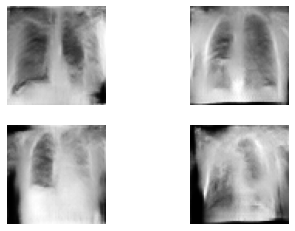

In [44]:
# plot the result
#200epoch,latent150
show_plot(X, 2)

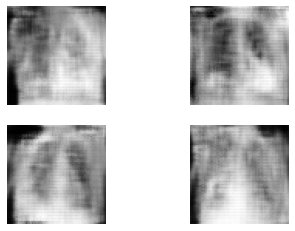

In [17]:
# plot the result
#100epoch
show_plot(X, 2)

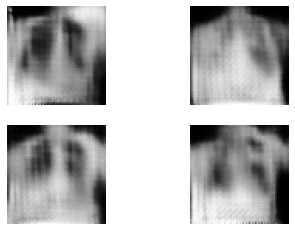

In [49]:
# plot the result
#v50epoch
show_plot(X, 2)

### Generate and Save images

In [20]:
#จำนวนที่ต้องgenerateเพื่อให้ข้อมูลมีจำนวนเท่ากัน
numSamples = 7287-2710
numSamples

4577

In [21]:
# generate images
latent_points = generate_latent_points(150, numSamples)
# generate images
X = model.predict(latent_points)

In [22]:
X.shape

(4577, 64, 64, 3)

In [23]:
cd /data/home/b6210407960/Dataset/Dataset3_GenImage/train/GenImage/

/data/home/b6210407960/Dataset/Dataset3_GenImage/train/GenImage


In [27]:
def save_image(iterator,numIm):
    for i in range(numIm):
        batch = (iterator[i]* 127.5) +127.5
        toRound = np.around(batch)
        image = toRound.astype('uint8')
        path = '/data/home/b6210407960/Dataset/Dataset3_GenImage/train/GenImage/'
        filename = path+'genCOVID'+str(i+1)+'.png'
        cv2.imwrite(filename, image)

In [28]:
save_image(X,numSamples)

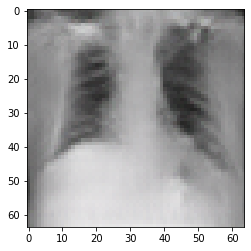

In [40]:
import matplotlib.pyplot as plt
im1 = cv2.imread('/data/home/b6210407960/Dataset/Dataset3_GenImage/train/GenImage/genCOVID10.png')
plt.imshow(im1)

In [41]:
im1.shape

(64, 64, 3)

In [42]:
ls /data/home/b6210407960/Dataset/Dataset3_GenImage/train/GenImage/

genCOVID1.png     genCOVID2029.png  genCOVID306.png   genCOVID4090.png
genCOVID10.png    genCOVID203.png   genCOVID3060.png  genCOVID4091.png
genCOVID100.png   genCOVID2030.png  genCOVID3061.png  genCOVID4092.png
genCOVID1000.png  genCOVID2031.png  genCOVID3062.png  genCOVID4093.png
genCOVID1001.png  genCOVID2032.png  genCOVID3063.png  genCOVID4094.png
genCOVID1002.png  genCOVID2033.png  genCOVID3064.png  genCOVID4095.png
genCOVID1003.png  genCOVID2034.png  genCOVID3065.png  genCOVID4096.png
genCOVID1004.png  genCOVID2035.png  genCOVID3066.png  genCOVID4097.png
genCOVID1005.png  genCOVID2036.png  genCOVID3067.png  genCOVID4098.png
genCOVID1006.png  genCOVID2037.png  genCOVID3068.png  genCOVID4099.png
genCOVID1007.png  genCOVID2038.png  genCOVID3069.png  genCOVID41.png
genCOVID1008.png  genCOVID2039.png  genCOVID307.png   genCOVID410.png
genCOVID1009.png  genCOVID204.png   genCOVID3070.png  genCOVID4100.png
genCOVID101.png   genCOVID2040.png  genCOVID3071.png  genCOVID4101.png
genCOVID1

genCOVID1321.png  genCOVID2352.png  genCOVID3383.png  genCOVID4413.png
genCOVID1322.png  genCOVID2353.png  genCOVID3384.png  genCOVID4414.png
genCOVID1323.png  genCOVID2354.png  genCOVID3385.png  genCOVID4415.png
genCOVID1324.png  genCOVID2355.png  genCOVID3386.png  genCOVID4416.png
genCOVID1325.png  genCOVID2356.png  genCOVID3387.png  genCOVID4417.png
genCOVID1326.png  genCOVID2357.png  genCOVID3388.png  genCOVID4418.png
genCOVID1327.png  genCOVID2358.png  genCOVID3389.png  genCOVID4419.png
genCOVID1328.png  genCOVID2359.png  genCOVID339.png   genCOVID442.png
genCOVID1329.png  genCOVID236.png   genCOVID3390.png  genCOVID4420.png
genCOVID133.png   genCOVID2360.png  genCOVID3391.png  genCOVID4421.png
genCOVID1330.png  genCOVID2361.png  genCOVID3392.png  genCOVID4422.png
genCOVID1331.png  genCOVID2362.png  genCOVID3393.png  genCOVID4423.png
genCOVID1332.png  genCOVID2363.png  genCOVID3394.png  genCOVID4424.png
genCOVID1333.png  genCOVID2364.png  genCOVID3395.png  genCOVID4425.png
genCOVI

load folder ลงเครื่อง <br>
`scp -P 22022 -r b6210407960@158.108.30.21:/data/home/b6210407960/Dataset/Dataset3_GenImage/train/GenImage .`